<a href="https://colab.research.google.com/github/macLeHoang/BTL-AI-AI-Colorization/blob/main/Ai_clorization_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [2]:
!pip install git+https://github.com/qubvel/classification_models.git

# !pip install tensorflow-datasets
# !pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-cbr_8m7i
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-cbr_8m7i
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 5.2 MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20046 sha256=cfa263eeced3d296a5562b88d0693dc1ac3a98c8d5e2af49fa40b06ee9cc607a
  Stored in directory: /tmp/pip-ephem-wheel-cache-3rjso4e8/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers


In [3]:
from skimage.color import rgb2lab, lab2rgb
# from skimage import transform
import numpy as np
from PIL import Image
from tqdm import tqdm
# import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
# import random
import cv2 as cv
# import json


import tensorflow as tf
from classification_models.tfkeras import Classifiers
# import tensorflow_datasets as tfds
# import tensorflow_io as tfio

In [4]:
def process(input_, nfilters_1 = 1024, nfilters_2 = 512, ksize = (3, 3), strides = 1, last_relu = True):
  x = tf.keras.layers.ZeroPadding2D()(input_)
  x = tf.keras.layers.Conv2D(nfilters_1, ksize, strides)(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.ZeroPadding2D()(x)
  x = tf.keras.layers.Conv2D(nfilters_2, ksize, strides)(x)

  if last_relu:
    x = tf.keras.layers.ReLU()(x)

  return x

In [5]:
def decoder(input_, concat, nfilters = 1024, ksize = (1, 1), strides = 1):
  x = tf.keras.layers.Conv2D(nfilters, ksize, strides)(input_)
  x = tf.keras.layers.ReLU()(x)
  out = tf.nn.depth_to_space(x, 2)
  x = tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(out)
  x = tf.keras.layers.Concatenate()([concat, x])
  x = tf.keras.layers.ReLU()(x)
  
  return x

In [6]:
class GENERATOR(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.ResNet18, _ = Classifiers.get('resnet18')
  
  def __call__(self):
    resnet18 = self.ResNet18(input_shape = (None, None, 3), 
                            #  weights = 'imagenet',
                             include_top = False)
  
    encoder_1 = resnet18.get_layer('bn0').output # encode 128 - shape = (None, 128, 128, 64)
    encoder_2 = resnet18.get_layer('stage2_unit1_bn1').output # encode 64 - shape = (None, 64, 64, 64)
    encoder_3 = resnet18.get_layer('stage3_unit1_bn1').output # encode 32 - shape = (None, 32, 32, 128)
    encoder_4 = resnet18.get_layer('stage4_unit1_bn1').output # encode 16 - shape = (None, 16, 16, 256)

    last_layer = resnet18.layers[-1].output
    bridge = process(last_layer)

    x = decoder(bridge, encoder_4) # shape = (None, 16, 16, 512)
    x = process(x, 512, 512)
    x = decoder(x, encoder_3, 1024) # shape = (None, 32, 32, 384)
    x = process(x, 384, 384)
    x = decoder(x, encoder_2, 768) # shape = (None, 64, 64, 256)
    x = process(x, 256, 256)
    x = decoder(x, encoder_1, 512) # shape = (None, 128, 128, 192)
    x = process(x, 96, 96)
    x = tf.keras.layers.Conv2D(384, (1, 1), 1)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.nn.depth_to_space(x, 2) # shape = (256, 256, 96)
    x = tf.keras.layers.Concatenate()([x, resnet18.input[:, :, :, 0:1]]) # shape = (None, 256, 256, 97)
    res = process(x, 97, 97, last_relu = False)
    x = tf.keras.layers.Add()([x, res])
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(2, (1, 1), 1)(x)
    x = tf.keras.layers.Activation('tanh')(x)

    return tf.keras.models.Model(inputs = resnet18.input, outputs = x)

In [7]:
gModel = GENERATOR()
generator = gModel()

In [8]:
gen_ckpt_list_dir = '/content/gdrive/MyDrive/AI_color_weights/Generator_v2'
gen_lastest_checkpoint = tf.train.latest_checkpoint(gen_ckpt_list_dir)
# gen_lastest_checkpoint = '/content/gdrive/MyDrive/AI_color_weights/Generator_v2/generator-20220616-091316'
print(gen_lastest_checkpoint)
generator.load_weights(gen_lastest_checkpoint)

/content/gdrive/MyDrive/AI_color_weights/Generator_v2/generator-20220630-104911


In [ ]:
# generator.summary()

In [9]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip

--2022-07-13 14:36:06--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.136.65
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.136.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  13.4MB/s    in 61s     

2022-07-13 14:37:08 (12.7 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



# New Section

In [21]:
def test(SIZE = (256, 256), x = 0):
  plt.figure(figsize = (20, 20))

  path = '/content/val2017'
  stack_img = np.zeros((1024, 2048, 3))

  for idx, name in (enumerate(os.listdir(path)[x : x + 16])):
    imgPath = os.path.join(path, name)
    img = Image.open(imgPath).convert('RGB').resize(SIZE)
    L = np.array(img.convert('L'))[np.newaxis, ..., np.newaxis] / 255.0 * 2 - 1
    L_ = np.repeat(L, 3, axis = -1)

    # img_ = img.convert('L').convert('RGB')
    # img_ = np.array(img_)
    # lab_ = rgb2lab(img_)
    # L = lab_[np.newaxis,..., 0:1] / 50 - 1

    ab_predict = generator(L_, training = False)

    L_img = (L + 1) * 50
    ab_predict = ab_predict * 110

    # lab_ = rgb2lab(np.array(img))
    # print(np.min(lab_[..., 1]), 
    #       np.max(lab_[..., 1]), 
    #       np.min(lab_[..., 2]), 
    #       np.max(lab_[..., 2]))

    lab_predict = np.concatenate([L_img[0], ab_predict.numpy()[0]], axis = -1)
    
    rgb_predict = lab2rgb(lab_predict)
    rgb_true = np.array(img)

    stack_img[(idx % 4)*256 : (idx % 4)*256 + 256,
              (idx // 4)*256 : (idx // 4)*256 + 256, :] = rgb_true / 255.0

    stack_img[(idx % 4)*256 : (idx % 4)*256 + 256,
              (idx // 4)*256 + 1024: (idx // 4)*256 + 256 + 1024, :] = rgb_predict

    # print(np.min(ab_predict[0, :, :, 0]), 
    #       np.max(ab_predict[0, :, :, 0]), 
    #       np.min(ab_predict[0, :, :, 1]), 
    #       np.max(ab_predict[0, :, :, 1]))

    # plt.subplot(5, 4, idx*2+1)
    # plt.axis('off')
    # plt.imshow(img)

    # plt.subplot(5, 4, idx*2+2)
  plt.axis('off')
  plt.imshow(stack_img)

  return stack_img

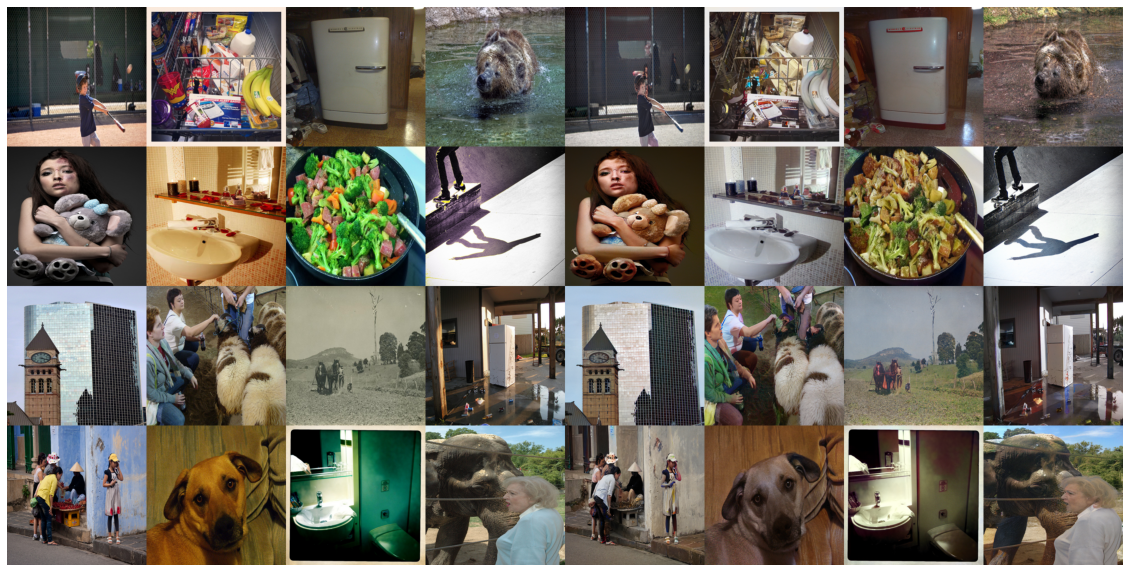

In [28]:
img = test(SIZE = (256, 256), x=0)

In [27]:
# img_ = np.uint8(img*255)
# import cv2 as cv

# img_ = cv.cvtColor(img_, cv.COLOR_BGR2RGB)
# cv.imwrite('./img1.jpg', img_)

True

In [ ]:
# !wget https://www.w3schools.com/css/img_5terre.jpg
# !wget https://cdn.pixabay.com/photo/2015/04/23/22/00/tree-736885__480.jpg
# !wget https://static.addtoany.com/images/dracaena-cinnabari.jpg

# img = Image.open('./img_5terre.jpg').convert('L').resize((512, 512))
# img_ = np.repeat(np.array(img)[np.newaxis, ..., np.newaxis], 3, axis = -1) / 255. * 2 -1

# ab = generator(img_) * 110
# l = (img_[0, :, :, 0:1] + 1) * 50

# lab = np.concatenate([l, ab[0].numpy()], axis = -1)
# rgb = lab2rgb(lab)

# plt.figure(figsize = (10, 10))
# plt.imshow(rgb)

# Evaluation

## Google form

In [ ]:
def to_folder(SIZE=(256, 256)):
  path = './val2017'
  ori_path = '/content/gdrive/MyDrive/AI_color_weights/Evaluation/Origin'
  gen_path = '/content/gdrive/MyDrive/AI_color_weights/Evaluation/Generated'

  for file_ in tqdm(os.listdir(path)):
    img = Image.open(os.path.join(path, file_)).resize(SIZE).convert('RGB')

    L = np.array(img.convert('L'))[np.newaxis, ..., np.newaxis] / 255.0 * 2 - 1
    L_ = np.repeat(L, 3, axis = -1)

    ab_predict = generator(L_, training = False)

    L_img = (L + 1) * 50
    ab_predict = ab_predict * 110

    lab_predict = np.concatenate([L_img[0], ab_predict.numpy()[0]], axis = -1)
    rgb_predict = lab2rgb(lab_predict)

    img.save(os.path.join(ori_path, file_))

    rgb = Image.fromarray(np.uint8(255*rgb_predict))
    rgb.save(os.path.join(gen_path, file_))

to_folder()

## Auc

In [ ]:
def root_mean_square(path, SIZE = (256, 256)):
  rms = []
  for fname in tqdm(os.listdir(path)[:2500]):
    iPath = os.path.join(path, fname)
    img = Image.open(iPath).convert('RGB').resize(SIZE)

    lab_target = rgb2lab(np.array(img))
    ab_target = lab_target[..., 1:]
    l_target = lab_target[..., 0:1]

    l_img = np.repeat(l_target, 3, axis = -1)[np.newaxis, ...]
    l_img = l_img / 255.0 * 2 -1

    ab_predict = generator(l_img, training = False)

    # rmse = np.mean((ab_predict.numpy()[0]*110 - ab_target)**2)**0.5 # rms per image

    # rmse = np.mean(np.sum((ab_predict.numpy()[0]*110 - ab_target)**2, axis = -1)**0.5)
    # rmse = np.mean(np.sum((ab_predict.numpy()[0]*110 - ab_target)**2, axis = -1))**0.5

    # rmse = np.mean(np.mean((ab_predict.numpy()[0]*110 - ab_target)**2, axis = (0, 1))**0.5) # rms per image v2 ?
    
    rmse = np.mean((ab_predict.numpy()[0]*110 - ab_target)**2, axis = 2)**0.5 # rms per pixel
    rms.extend(rmse.ravel().tolist())

  return rms

In [ ]:
a = root_mean_square('/content/val2017')

100%|██████████| 2500/2500 [04:28<00:00,  9.33it/s]


In [ ]:
import pickle
# with open('/content/gdrive/MyDrive/AI_color_weights/abv6_rms.txt', 'wb') as f:
#   pickle.dump(a, f)

with open('/content/gdrive/MyDrive/AI_color_weights/ab_rms.txt', 'rb') as f:
  a = pickle.load(f)

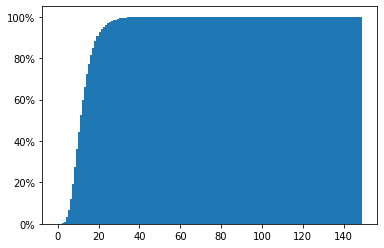

In [ ]:
from matplotlib.ticker import PercentFormatter

b = plt.hist(a, bins = np.arange(0, 150, 1), cumulative = True, density = True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

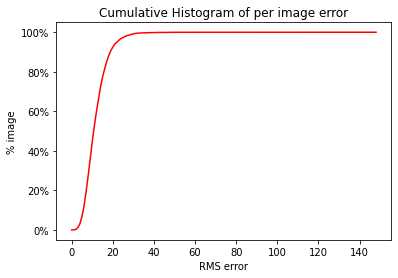

In [ ]:
plt.plot(b[1][:-1], b[0], color = 'red')
plt.title('Cumulative Histogram of per image error')
plt.xlabel('RMS error')
plt.ylabel('% image')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [ ]:
from sklearn.metrics import auc
auc(b[1][:-1], b[0]) / 150

0.923923832010905

## Classification Task

In [ ]:
!wget https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-matched-frequency.tar.gz
!tar -xf /content/imagenetv2-matched-frequency.tar.gz

In [ ]:
vgg_ = tf.keras.applications.vgg19.VGG19(include_top=True, 
                                          weights='imagenet')
output = vgg_.layers[-1].output
model = tf.keras.models.Model(inputs = vgg_.input, outputs = output)

In [ ]:
real_top_1 = 0
real_top_5 = 0

for folder in tqdm(os.listdir('/content/imagenetv2-matched-frequency-format-val')):
  path = os.path.join('/content/imagenetv2-matched-frequency-format-val', folder)
  true_value = int(folder)

  for img_ in os.listdir(path):
    img = Image.open(os.path.join(path, img_)).resize((224, 224))
    img = np.array(img)[np.newaxis, ...]
    img = tf.keras.applications.vgg19.preprocess_input(img)
    x = model(img, training = False)

    max_ = np.argmax(x.numpy())

    if max_ == true_value:
      real_top_1 += 1
      real_top_5 += 1
    else:
      top5_ind = np.argpartition(x.numpy(), -5)[-5:]
      if np.any(max_ == top5_ind):
        real_top_5 += 1

real_top_1, real_top_5

In [ ]:
color_top_1 = 0
color_top_5 = 0

for folder in tqdm(os.listdir('/content/imagenetv2-matched-frequency-format-val')):
  path = os.path.join('/content/imagenetv2-matched-frequency-format-val', folder)
  true_value = int(folder)

  for img_ in os.listdir(path):
    img = Image.open(os.path.join(path, img_)).resize((224, 224)).convert('L')
    img = np.array(img)[np.newaxis, ...] / 255.0 * 2 - 1
    img = np.repeat(img[..., np.newaxis], 3, axis = -1)
    ab = generator(img)

    l = (img + 1) * 50
    ab = ab * 110

    lab = np.concatenate([l[0, :, :, 0:1], ab[0]], axis = -1)
    rgb = lab2rgb(lab)

    rgb = np.uint8(rgb*255)[np.newaxis, ...]

    rgb = tf.keras.applications.vgg19.preprocess_input(rgb)
    x = model(rgb, training = False)

    max_ = np.argmax(x.numpy())

    if max_ == true_value:
      color_top_1 += 1
      color_top_5 += 1
    else:
      top5_ind = np.argpartition(x.numpy(), -5)[-5:]
      if np.any(top5_ind == max_):
        color_top_5 += 1
        
color_top_1, color_top_5

In [ ]:
gray_top_1 = 0
gray_top_5 = 0

for folder in tqdm(os.listdir('/content/imagenetv2-matched-frequency-format-val')):
  path = os.path.join('/content/imagenetv2-matched-frequency-format-val', folder)
  true_value = int(folder)

  for img_ in os.listdir(path):
    img = Image.open(os.path.join(path, img_)).resize((224, 224)).convert('L').convert('RGB')
    img = np.array(img)[np.newaxis, ...]
    img = tf.keras.applications.vgg19.preprocess_input(img)
    x = model(img, training = False)

    max_ = np.argmax(x.numpy())
    if max_ == true_value:
      gray_top_1 += 1
      gray_top_5 += 1
    else:
       top5_ind = np.argpartition(x.numpy(), -5)[-5:]
       if np.any(top5_ind == max_):
         gray_top_5 += 1

gray_top_1, gray_top_5